### 1. 近傍法による異常検知
#### スライド窓による時系列データの変換
1次元の時系列を考える。観測値として長さ$T$の時系列が$D=\{\xi^{(1)},\xi^{(2)},\cdots,\xi^{(T)}\}$のように与えられたとする。  
$w$個の隣接した観測値をまとめて
$$
\boldsymbol{x}^{(1)}=
\left(\begin{array}{c}
\xi^{(1)}\\
\xi^{(2)}\\
\vdots\\
\xi^{(w)}
\end{array}\right),\ 
\boldsymbol{x}^{(2)}=
\left(\begin{array}{c}
\xi^{(2)}\\
\xi^{(3)}\\
\vdots\\
\xi^{(w+1)}
\end{array}\right),\ \cdots
$$
のように、データを$w$次元ベクトルの集まりとして表すこととする。  
長さ$T$の観測値からなる時系列データは
$$
N=T-w+1
$$
本の$w$次元ベクトルに変換される。  
長さ$w$の窓を左から右に動かして、つぎつぎに長さ$w$の時系列片をつくっていく。この窓のことを**スライド窓**と呼ぶ。  
スライド窓により生成したベクトルのことを、**部分時系列**と呼ぶことがある。
#### 異常部位検出問題
ある程度滑らかな実数時系列データの場合、隣り合った部分時系列の要素の値はほとんど等しくなり、これを自己一致や自明な一致などと呼ぶ。  
>手順1(異常部位発見)　訓練用の時系列$D_{tr}$と、検証用の時系列$D$を用意し、  
それぞれを窓幅$w$により、部分時系列ベクトルの集合に変換しておく。  
距離を計算するための関数distを用意する。異常度の判定に使う近傍数$k$を決めておく。  
また、$k$近傍から異常度を計算する関数scoreを用意する。
>1. $D$各要素$\boldsymbol{x}^{(t)}$について以下を行う($t=1,\cdots,N$)  
　a.距離の計算：distを用いて$D_{tr}$の各要素と$\boldsymbol{x}^{(t)}$の距離を計算する  
　b.スコアの計算：上記で求めた距離のうち最小のもの$k$個を選びscore関数により異常度を計算し記憶する  
>2. 異常度が最大のものを異常部位として列挙する

distについては、典型的にはユークリッド距離、ときにマハラノビス距離は使われるが、pノルムを使うこともできる。  
類似度も使うことができ、最もよく使われるのが**動的時間伸縮法**による類似度である。  
scoreに関しては、$k=1$と選んだうえで、最近傍までの距離の値そのものを異常度とすることが多い。  
形式的に書くと次の通りである。
$$
scpre(\boldsymbol{x}^{(t)},D_{tr})=(\boldsymbol{x}^{(t)}の最近傍までの距離)
$$
$k>1$として平均値を考えることもできる。

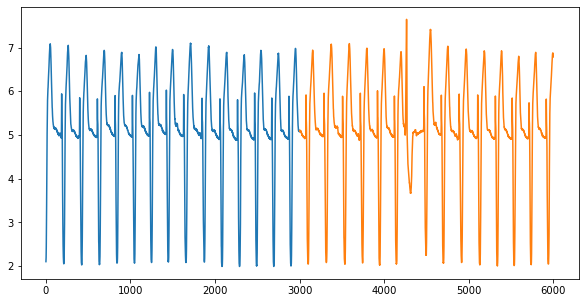

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/qtdbsel102.txt', sep='\t').reset_index()
data = np.array(data)

plt.figure(figsize=(10,5))
plt.plot(np.arange(3000),data[:3000,2])
plt.plot(np.arange(3000,6000), data[3000:6000,2])

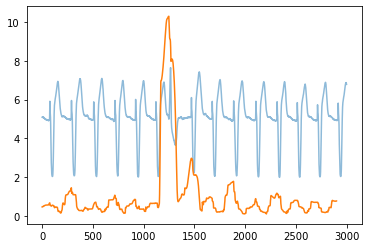

In [4]:
from scipy.spatial.distance import cdist

w = 100 # 窓幅
nk = 1 # 近傍点

# 訓練用
Xtr = data[:3000,2] 
# 窓幅ずつ切り出していく
Dtr = np.array([Xtr[i:i+w] for i in range(3001-w)])

# テスト用
X = data[3000:6000,2]
# 窓幅ずつ切り出していく
D = np.array([X[i:i+w] for i in range(3001-w)])

# 距離の計算
D_dist = cdist(D, Dtr, metric='euclidean')

# 異常度の計算
# 近傍点との距離
a = np.min(D_dist, axis=1)

plt.plot(data[3000:6000,2], alpha=.5)
plt.plot(a)

### 2. 特異スペクトル変換法
前節での手法では、時系列に含まれるノイズが近傍の計算に多大な影響を与えるため誤検出などが起きる。  
ノイズえお除去するために、ここでは部分空間法を用いた手法を説明する。  
#### 特徴的なパターンの算出
変化点検知では、異常パターンを検知することを目的にしているが、変化が起こった箇所には外れ値が生ずることもあるが、必ずしもそうとは限らない。  
観測値として長さ$T$の時系列が$D=\{\xi^{(1)},\xi^{(2)},\cdots,\xi^{(T)}\}$のように与えられたとする。  
時刻$t$の周りに、過去側と現在側において、$k$本の部分時系列を使って、2つのデータ行列$X_1$と$X_2$をつくる。  
$$
X_1^{(t)}=[\boldsymbol{x}^{(t-k-w+1)},\cdots,\boldsymbol{x}^{(t-w-1)},\boldsymbol{x}^{(t-w)}]\\
X_2^{(t)}=[\boldsymbol{x}^{(t-k+L-w+1)},\cdots,\boldsymbol{x}^{(t-w-1)},\boldsymbol{x}^{(t-w+L)}]
$$
それぞれの列ベクトルは長さ$w$の部分時系列である。  
$X_1^{(t)}$は$\xi^{(t-k-w+1)}$から$\xi^{(t-1)}$までのデータ、すなわち時刻$t$の一つ前までのデータを使って構成されることがわかる。  
データ行列$X_1$は、部分時系列の直近の過去の来歴の情報が入っているため、**履歴行列**と呼ぶことがある。  
対して、$X_2$はテスト行列などと呼ばれることがある。  
$L$は、履歴行列とテスト行列の相互位置を定める非負整数で、通常**ラグ**と呼ばれる。  
部分時系列の一次結合を考える。$X_1^{(t)}$の場合であれば、
$$
\boldsymbol{x}^{(t-k)}v_k^{(t)}+\cdots+\boldsymbol{x}^{(t-2)}v_k^{(t)}+\boldsymbol{x}^{(t-1)}v_k^{(t)}\ すなわち\ X_1^{(t)}\boldsymbol{v}^{(t)}
$$
となる。ただし、$\boldsymbol{v}^{(t)}=[v_1^{(t)},v_2^{(t)},\cdots,v_k^{(t)}]^T$であり、$\boldsymbol{v}^{(t)T}\boldsymbol{v}^{(t)}=1$という制約を課す。  
最適な一次結合を求める問題は、
$$
|X_1^{(t)}\boldsymbol{v}^{(t)}|^2→最大化\ subject\ to\ \boldsymbol{v}^{(t)T}\boldsymbol{v}^{(t)}=1
$$
となる。  
次のことが分かる。  
1. $X_1^{(t)}$の上位$m$個の左特異ベクトル$\{\boldsymbol{u}^{(t,1)},\boldsymbol{u}^{(t,2)},\cdots,\boldsymbol{u}^{(t,m)}\}$が過去側の主部分空間の基底
2. $X_2^{(t)}$の上位$m$個の左特異ベクトル$\{\boldsymbol{q}^{(t,1)},\boldsymbol{q}^{(t,2)},\cdots,\boldsymbol{q}^{(t,m)}\}$が現在側の主部分空間の基底

上記部分空間をまとめて、次のような$w×m$行列を定義する。
$$
U_m^{(t)}=[\boldsymbol{u}^{(t,1)},\boldsymbol{u}^{(t,2)},\cdots,\boldsymbol{u}^{(t,m)}]\\
Q_m^{(t)}=[\boldsymbol{q}^{(t,1)},\boldsymbol{q}^{(t,2)},\cdots,\boldsymbol{q}^{(t,m)}]
$$
それぞれの列ベクトルで張られる空間を$span(U_m^{(t)})$と$$span(Q_m^{(t)})$$と表しておく。  
特異値分解により時系列データの特徴パターンを求め、それに基づき次節で述べる方法で変化度を求める手法を**特異値スペクトル変換**または特異スペクトル解析と呼ぶ。
主成分分析との違いは、部分時系列の平均値を引かないということである。  
問題にしているのは部分時系列のベクトルのなす分散ではなく、ベクトルそのものであるからである。
#### 変化度の定義
カーネル主成分分析における変化解析問題において導入した式とまったく同様に、ここでも行列2ノルムを使って
$$
\begin{align}
a(t)&=1-|U_m^{(t)T}Q_m^{(t)}|_2^2\\
&=1-\bigl(U_m^{(t)T}Q_m^{(t)}の最大特異値 \bigr)^2
\end{align}
$$
と定義することができる。  
履歴行列$X_1^{(t)}$は、$\xi^{(t-k-w+1)}$から$\xi^{(t-1)}$までのデータを含むので、$t-k-w+1=1$を満たす時刻より過去側では計算はできない。  
したがって$t=k+w$が変化度の計算の始まりとなる。  
履歴行列$X_2^{(t)}$は、$\xi^{(t-k+L-w+1)}$から$\xi^{(t+L-1)}$までのデータを含むので、$t+L-1=T$を満たす時刻より$t$を超えるとテスト行列が構成できなくなる。  
したがって$t=T-L+1$が変化度の計算の終わりとなる。  
>手順2(特異スペクトル変換)　時刻$D=\{\xi^{(1)},\xi^{(2)},\cdots,\xi^{(T)}\}$を用意する。窓幅$w$、履歴行列の列サイズ$k$、ラグ$L$、パターン数$m$を決める。
>1. $t=(w+k),\cdots,(T-L+1)$においてつぎの計算を行う。  
　a.(履歴行列とテスト行列)：$H_1^{(t)}$と$H_2^{(t)}$をつくる。($X_1^{(t)},X_2^{(t)}$の式)  
　b.(特異値分解)：$H_1^{(t)},H_2^{(t)}$を特異値分解し、左特異ベクトルの行列$U_m^{(t)},Q_m^{(t)}$を求める  
　c.(スコアの計算)：$U_m^{(t)T}Q_m^{(t)}$の最大特異値を計算し、変化度$a(t)$を計算する



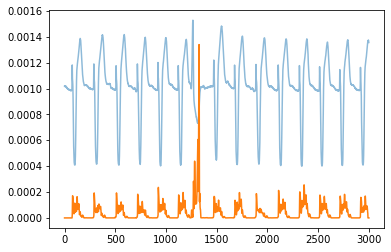

In [10]:
xi = data[3000:6001, 2]
w = 50 # 窓幅
m = 2 # パターン数
k = int(w/2) # 履歴行列の列サイズ 25
L = int(k/2) # ラグ 12
Tt = len(xi) # 3000

# 順番にスコアの計算を行う
score = np.zeros(Tt)
for t in np.arange(w+k, Tt-L+1): # 75 ~ 2989
    # 履歴行列を作る
    tstart = t-w-k # 始点
    tend = t-1 # 終点

    x1 = xi[tstart:tend] # データの取り出し
    X1 = np.array([x1[i:(i+w)] for i in range(len(x1)-w)]).T # 窓幅ごとに切り出す
    X1 = X1[::-1,:]
    
    # テスト行列を作る
    # 履歴行列のLだけ後のデータ
    tstart = t-w-k+L # 始点
    tend = t-1+L # 終点
    
    x2 = xi[tstart:tend] # データの取り出し
    X2 = np.array([x2[i:(i+w)] for i in range(len(x2)-w)]).T # 窓幅ごとに切り出す
    X2 = X2[::-1,:]
    
    # 特異値分解
    U = np.linalg.svd(X1)[0][:,:m]
    Q = np.linalg.svd(X2)[0][:,:m]
    
    # UQの特異値分解
    sig = np.linalg.svd(U.T@Q)[1][0]
    
    # スコアの計算
    score[int(t)] = 1 - sig**2

plt.plot(data[3000:6000,2]*0.0002, alpha=.5)
plt.plot(score)

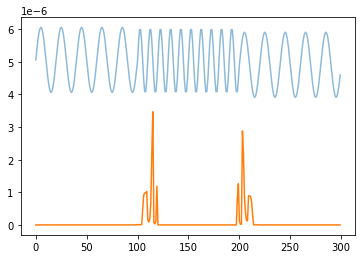

In [13]:
# データの作成
x1 = np.arange(0,10,0.1)
x2 = np.arange(10,20,0.1)
x3 = np.arange(20,30,0.1)

# y2部分で周波数が異なるデータ
y1 = np.sin(np.pi*x1) + np.random.normal(len(x1), scale=0.07)
y2 = np.sin(2*np.pi*x2) + np.random.normal(len(x2), scale=0.07)
y3 = np.sin(np.pi*x3) + np.random.normal(len(x3), scale=0.07)
xi = np.concatenate([y1, y2,y3])

# 各パラメータ
w = 10
m = 2
k = 10
L = 5
Tt = len(xi)

score = np.zeros(Tt)
for t in np.arange(w+k, Tt-L+1):
    tstart = t-w-k
    tend = t-1
    x1 = xi[tstart:tend]
    X1 = np.array([x1[i:(i+w)] for i in range(len(x1)-w)]).T
    X1 = X1[::-1,:]
    
    tstart = t-w-k+L
    tend = t-1+L
    x2 = xi[tstart:tend]
    X2 = np.array([x2[i:(i+w)] for i in range(len(x2)-w)]).T
    X2 = X2[::-1,:]
    
    U = np.linalg.svd(X1)[0][:,:m]
    Q = np.linalg.svd(X2)[0][:,:m]
    sig = np.linalg.svd(U.T@Q)[1][0]
    score[int(t)] = 1 - sig**2

plt.plot((xi-95)*10**(-6), alpha=.5)
plt.plot(score)

### 3. 自己回帰モデルによる異常検知
いまの観測値$\xi^{(t)}$が、前の数個(例えば$r$個)の観測値の一次結合
$$
\xi^{(t)}\approx \alpha_1\xi^{(t-r)}+\alpha_2\xi^{(t-r+1)}+\cdots+\alpha_{r-1}\xi^{(t-2)}+\alpha_{r}\xi^{(t-1)}
$$
と考えるのが、**次数$r$の自己回帰モデル**である。
#### 1変数の自己回帰モデル
長さ$T$の時系列データからは、$t=r+1$から$T$までの合計$T-r$個の観測値に対する予測値を作ることができる。
$$
y^{(t)}=\xi^{(t+r)},\ \boldsymbol{x}^{(t)}=
\left(\begin{array}{c}
\xi^{(t)}\\
\xi^{(t+1)}\\
\vdots\\
\xi^{(t+r-1)}
\end{array}\right),\ 
N=T-r
$$
と定義し、元の時系列データ$\{\xi^{(1)},\xi^{(2)},\cdots,\xi^{(T)}\}$を、
$$
D=\{(\boldsymbol{x}^{(1)},y^{(1)}),\cdots,(\boldsymbol{x}^{(N)},y^{(N)}) \}
$$
というデータに変換したと考える。  
予測誤差を正規分布でモデル化するとして、
$$
p(y|\boldsymbol{\alpha},\sigma^2)=N(y|\boldsymbol{\alpha}^T\boldsymbol{x},\sigma^2)
$$
とおく。$D$に基づき対数尤度関数の式を立てると
$$
L(\boldsymbol{\alpha},\sigma^2)=-\frac{N}{2}\ln(2\pi\sigma^2)-\frac{1}{2\sigma^2}\sum_{n=1}^N\bigl[y^{(n)}-\boldsymbol{\alpha}^T\boldsymbol{x}^{(n)} \bigr]^2
$$
となる。
これを$\boldsymbol{\alpha}$および$\sigma^{-2}$で微分してゼロと等値することにより
$$
\hat{\boldsymbol{\alpha}}=[XX^T]^{-1}X\boldsymbol{y}_N\\
\hat{\sigma}^2=\frac{1}{N}\sum_{n=1}^N\bigl[y^{(n)}-\boldsymbol{\alpha}^T\boldsymbol{x}^{(n)} \bigr]^2
$$
が得られる。
$\boldsymbol{y}_N=[y^{(1)},\cdots,y^{(N)}]^T$および$X=[\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)}]$である。  
#### ベクトル自己回帰モデル
時刻$t$での観測値が、$M$次元ベクトル$\boldsymbol{\xi}^{(t)}$だとした自己回帰モデル
$$
\boldsymbol{\xi}^{(t)}\approx A_1\boldsymbol{\xi}^{(t-r)}+A_2\boldsymbol{\xi}^{(t-r+1)}+\cdots+A_{r-1}\boldsymbol{\xi}^{(t-2)}+A_{r}\boldsymbol{\xi}^{(t-1)}
$$
を考える。この場合、回帰係数に当たるものは$M×M$行列となる。
次の量を定義する。
$$
A=[A_1,\cdots,A_r],\ \boldsymbol{x}^{(t)}=
\left(\begin{array}{c}
\boldsymbol{\xi}^{(t)}\\
\boldsymbol{\xi}^{(t+1)}\\
\vdots\\
\boldsymbol{\xi}^{(t+r-1)}
\end{array}\right),\ 
\boldsymbol{y}^{(t)}=\boldsymbol{\xi}^{(t+r)}
$$
$A$は$M×M$の係数行列で、$\boldsymbol{x}^{(t)}$は$rM$次元の長いベクトルである。  
問題は、データ
$$
D=\{(\boldsymbol{x}^{(1)},\boldsymbol{y}^{(1)}),\cdots,(\boldsymbol{x}^{(N)},\boldsymbol{y}^{(N)}) \}
$$
を基に、自己回帰モデル$\boldsymbol{y}^{(t)}\approx A\boldsymbol{x}^{(t)}$の係数行列$A$を推定する問題となる($N=T-r$)。  
このモデルを**次数$r$のベクトル自己回帰モデル**と呼ぶ。  
予測誤差を正規分布でモデル化するとし
$$
\begin{align}
p(\boldsymbol{y}|A,\Sigma)&=N(\boldsymbol{y}|A\boldsymbol{x},\Sigma)\\
&=\frac{1}{(2\pi)^{M/2}|\Sigma|^{1/2}}\exp\biggl[-\frac{1}{2}(\boldsymbol{y}-A\boldsymbol{x})^T\Sigma^{-1}(\boldsymbol{y}-A\boldsymbol{x}) \biggr]
\end{align}
$$
とおく。これは$M$次元の多変量正規分布である。  
対数尤度関数は
$$
L(A,\Sigma|D)=-\frac{MN}{2}\ln(2\pi)-\frac{N}{2}\ln|\Sigma|-\frac{1}{2}Tr\biggl[\Sigma^{-1}\sum_{n=1}^N(\boldsymbol{y}^{(n)}-A\boldsymbol{x}^{(n)})^T(\boldsymbol{y}^{(n)}-A\boldsymbol{x}^{(n)}) \biggr]
$$
さらに
$$
X=[\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)}],\ T=[\boldsymbol{y}^{(1)},\cdots,\boldsymbol{y}^{(N)}]
$$
とおくと
$$
L(A,\Sigma|D)=-\frac{MN}{2}\ln(2\pi)-\frac{N}{2}\ln|\Sigma|-\frac{1}{2}Tr\biggl[\Sigma^{-1}(Y-AX)(Y-AX)^T \biggr]
$$
という表式が得られる。
$A,\Sigma$で微分してゼロと等値とすると
$$
\frac{\partial L}{\partial \Sigma^{-1}}=\frac{N}{2}-\frac{1}{2}(Y-AX)(Y-AX)^T\\
\frac{\partial L}{\partial A}=YX^T-AXX^T
$$
が成り立つことが分かり、以下の最尤推定値が得られる。
$$
\hat{\Sigma}=\frac{1}{N}(Y-\hat{A}X)(Y-\hat{A}X)^T\\
\hat{A}=YX^T(XX^T)^{-1}
$$
#### 次数$r$の決定
時系列モデリングの場合、モデル選定基準としては赤池情報量基準(AIC)が標準的に使われる。  
$M$次元の時系列データに対する次数$r$のベクトル自己回帰モデルの場合、$M×M$の共分散行列$\Sigma$があるので、  
パラメータの数としては$rM^2+M(M+1)/2$となる。したがってAICは
$$
AIC(r)=-2L(\hat{A},\hat{\Sigma}|D)+2rM^2+M(M+1)
$$
となる。対数尤度関数の式に$\hat{\Sigma}$を使って
$$
AIC(r)=N\{M\ln(2\pi)+\ln|\hat{\Sigma}|+M\}+M(M+1)+2rM^2
$$
となることがわかる。  
$r$に関係しない部分を除いて$N$で割ると
$$
\ln|\hat{\Sigma}|+\frac{2rM^2}{N}
$$
という式となる。

#### 実行例
外れ値検出の問題であれば、ホテリング理論を流用して次のように定義する。
$$
a_{M=1}(\xi^{(t)})=\frac{1}{\hat{\sigma}^2}\biggl[\xi^{(t)}-\sum_{l=1}^r\hat{\alpha}_l\xi^{(t-l)} \biggr]^2\\
a_M(\boldsymbol{\xi}^{(t)})=(\boldsymbol{\xi}^{(t)}-\hat{A}\boldsymbol{x}^{(t-r)})^T\hat{\Sigma}^{-1}(\boldsymbol{\xi}^{(t)}-\hat{A}\boldsymbol{x}^{(t-r)})
$$
ここで$\boldsymbol{x}^{(t-r)}$は$\boldsymbol{\xi}^{(t-r)}$から$\boldsymbol{\xi}^{(t-1)}$までを縦に並べたベクトルである。
>手順3(自己回帰モデルによる異常検知)　訓練用の時系列$D_{tr}$と、テスト用の時系列$D$を用意する。  
データを観察して次数$r$の候補$r_1,r_2,\cdots$を決める。  
>1. モデルの推定：次数候補$r_1,r_2,\cdots$について以下を行い、AIC最小のモデルと、対応するモデルパラメータを求める。  
　a.データの準備：$D_{tr}$を、回帰問題のデータに変換する
　b.最尤推定：$M=1$の場合は「1変数の自己回帰モデル」の式を使い、$M>1$の場合は「ベクトル自己回帰モデル」の式を使って未知パラメータを求め、記憶する  
　c.AICの計算：AICを求め、記憶する  
>2. 異常検知：$D$に含まれる$\boldsymbol{\xi}^{(1)},\boldsymbol{\xi}^{(2)},\cdots$に対して以下を行う  
　a.異常度の計算：異常度の計算を行う  
　b.異常判定：異常度が閾値を超えたら異常と判定する

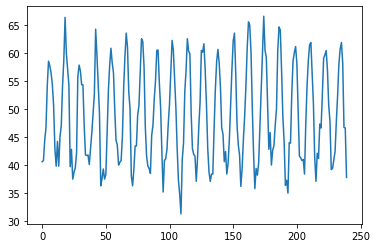

In [15]:
nottem = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/nottem.csv').reset_index()
nottem = np.array(nottem)[:,1]
plt.plot(nottem)

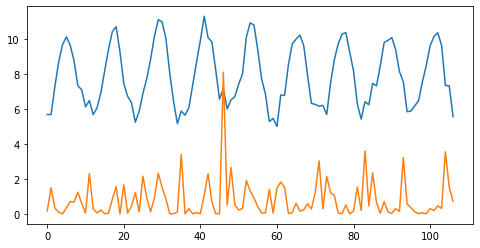

In [16]:
from statsmodels.tsa import ar_model

nottem = pd.read_csv('nottem.csv').reset_index()
nottem = np.array(nottem)[:,1]
plt.plot(nottem)

# データの分割
Dtr = nottem[:120] # 訓練用
xi = nottem[120:] # テスト用
Tt = len(xi)

# 中心化
xmean = np.mean(Dtr)
Dtr_center = Dtr - xmean

aic = []
# 最適なラグを探索
# AICで評価
for i in range(20):
    maxlag = i
    model = ar_model.AutoReg(Dtr_center, lags=maxlag, trend='n', old_names=True)
    results = model.fit()
    aic.append(results.aic)

# AICが低いモデルを作成
r = np.argmin(aic)
model = ar_model.AutoReg(Dtr_center, lags=r, trend='n', old_names=True)
results = model.fit()

# 係数を取得
alpha = results.params

# σ2を取得
sig2 = results.sigma2

# テスト
# 中心化
xi_center = xi - xmean

# 切っていされた「ラグ」ずつデータを切り出す
X = np.array([xi_center[i:(i+r)] for i in range(len(xi_center)-r)])
X = X[:,::-1]

# 予測値の計算
pred = X@alpha+xmean

# 異常度の計算
a = (xi[r:] - pred)**2 / sig2

plt.figure(figsize=(8,4))
plt.plot((xi[r:]-10)*0.2)
plt.plot(a)

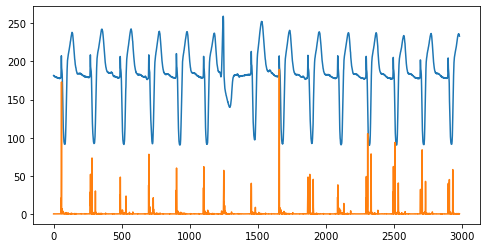

In [17]:
data = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/qtdbsel102.txt', sep='\t').reset_index()
data = np.array(data)

# データの分割
Dtr = data[:3000, 2]
xi = data[3000:6001, 2]
Tt = len(xi)

# 中心化
xmean = np.mean(Dtr)
Dtr_center = Dtr - xmean

aic = []
# 最適なラグを探索
# AICで評価
for i in range(20):
    maxlag = i
    model = ar_model.AutoReg(Dtr_center, lags=maxlag, trend='n', old_names=True)
    results = model.fit()
    aic.append(results.aic)

# AICが低いモデルを作成
r = np.argmin(aic)
model = ar_model.AutoReg(Dtr_center, lags=r, trend='n', old_names=True)
results = model.fit()

# 係数を取得
alpha = results.params

# σ2を取得
sig2 = results.sigma2

# テスト
# 中心化
xi_center = xi - xmean

# 切っていされた「ラグ」ずつデータを切り出す
X = np.array([xi_center[i:(i+r)] for i in range(len(xi_center)-r)])
X = X[:,::-1]

# 予測値の計算
pred = X@alpha+xmean

# 異常度の計算
a = (xi[r:] - pred)**2 / sig2

plt.figure(figsize=(8,4))
plt.plot((xi[r:]+1)*30)
plt.plot(a)

#### 4. 状態空間モデルによる異常検知
#### 線形状態空間モデル
時刻$t$における系の内部状態を$\boldsymbol{z}^{(t)}$という$m$次元ベクトルで表し、観測される量を$\boldsymbol{x}^{(t)}$という$M$次元ベクトルで表す。  
**線形状態空間モデル**とは
$$
\boldsymbol{x}^{(t)}\approx C\boldsymbol{z}^{(t)}\\
\boldsymbol{z}^{(t)}\approx A\boldsymbol{z}^{(t-1)}
$$
という式が成り立つと考えるモデルである。ここで$A$は$m×m$行列、$C$は$M×n$行列である。  
$\boldsymbol{z}^{(t)}$は直接観測できないと想定されるので、潜在変数とも呼ばれる。 
多くの場合、内部状態の遷移と、内部状態からの観測量への変換は正規分布に従って確率的に行われると仮定される。  
$$
p(\boldsymbol{x}^{(t)}|\boldsymbol{z}^{(t)})=N(\boldsymbol{x}^{(t)}|C\boldsymbol{z}^{(t)},R)\\
p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})=N(\boldsymbol{z}^{(t)}|A\boldsymbol{z}^{(t-1)},Q)
$$
がモデルとなる。  
ここで、$Q$は内部状態の遷移のばらつきを表す$m×m$の共分散行列で、$R$は観測量のばらつきを表す$M×M$の共分散行列である。  
始点の$t=1$に対応するため、上記に加えて
$$
p(\boldsymbol{z}^{(1)})=N(\boldsymbol{z}^{(1)}|\boldsymbol{z}_0,Q_0)
$$
を仮定しておく。  
解くべき問題は2つあり、
- 観測データが得られたときに、状態変数の系列$\{\boldsymbol{z}^{(1)},\cdots,\boldsymbol{z}^{(t)}\}$を推定すること
- 未知パラメータ$A,C,Q,R$を、データ$D$および状態変数系列から推定すること

である。
#### 部分空間同定法：状態系列の推定
$M$次元の観測量が$T$個$\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(t)}$のようにデータとして与えられているとする。  
まず、状態系列$\boldsymbol{z}^{(1)},\cdots,\boldsymbol{z}^{(t)}$を再現するという問題を考える。  
部分空間同定法では、「過去と未来が共通にもっているパターンがもしあれば、それが潜在状態と関係しているはずだ」という考えに基づいて状態系列を定めていく。  
時系列の長さが十分に長いとして、時系列を長さ$w$の窓幅で切り取り、時刻$t$の過去側の領域pと未来側の領域f$N$本の部分時系列のベクトルを作る。  
例えば時刻$t$を先頭とする部分時系列のベクトルは次の通りである。
$$
\boldsymbol{X}^{(t)}=
\left(\begin{array}{c}
\boldsymbol{x}^{(t)}\\
\boldsymbol{x}^{(t+1)}
\vdots\\
\boldsymbol{x}^{(t+w-1)}
\end{array}\right)
$$
それぞれの部分時系列ベクトルは$Mw$次元の長いベクトルとなるが、元時系列は重分位長いとして$N\gg Mw$と考える。  
部分時系列のベクトルを列ベクトルとする行列$X_p,X_f$を次のように定義する。
$$
X_p=[\boldsymbol{X}^{(t-N)},\cdots,\boldsymbol{X}^{(t-2)},\boldsymbol{X}^{(t-1)}]\\
X_f=[\boldsymbol{X}^{(t)},\boldsymbol{X}^{(t+1)},\cdots,\boldsymbol{X}^{(t+N-1)}]
$$
行列$X_p,X_f$と状態変数との関係を調べるために、
$$
\boldsymbol{x}^{(1)}\approx C\boldsymbol{z}^{(1)},\ \boldsymbol{x}^{(2)}\approx CA\boldsymbol{z}^{(1)},\ \boldsymbol{x}^{(3)}\approx CA^2\boldsymbol{x}^{(1)},\cdots
$$
という関係式に注目する。このような関係式を使うと
$$
\boldsymbol{X}^{(t)}\approx
\left(\begin{array}{c}
C\boldsymbol{z}^{(t)}\\
C\boldsymbol{z}^{(t+1)}\\
\vdots\\
C\boldsymbol{z}^{(t+w-1)}
\end{array}\right)\approx
\left(\begin{array}{c}
C\boldsymbol{z}^{(t)}\\
CA\boldsymbol{z}^{(t)}\\
\vdots\\
CA^{w-1}\boldsymbol{z}^{(t)}
\end{array}\right)=
\left(\begin{array}{c}
C\\
CA\\
\vdots\\
CA^{w-1}
\end{array}\right)\boldsymbol{z}^{(t)}=
\Gamma \boldsymbol{z}^{(t)}
$$
のように、任意の時刻$t$において$\boldsymbol{X}^{(t)}$を$\boldsymbol{z}^{(t)}$を使って表現できることがわかる。  
最右辺は$Mw×m$行列$\Gamma$の定義式で、この行列は制御理論では可観測性行列と呼ばれる。  
これを使うと、行列$X_p,X_f$と内部状態をつなぐ関係式$X_p\approx \Gamma Z_p$および$X_f\approx \Gamma Z_f$が得られる。  
ただし、
$$
Z_p=[\boldsymbol{z}^{(t-N)},\cdots,\boldsymbol{z}^{(t-2)},\boldsymbol{z}^{(t-1)}]\\
Z_f=[\boldsymbol{z}^{(t)},\boldsymbol{z}^{(t+1)},\cdots,\boldsymbol{z}^{(t+N-1)}]
$$
さらに、$Z_p$は$Z_f$の時刻を$N$ステップ進めたものであるから、
$$
X_p\approx \Gamma Z_p,\ X_f\approx \Gamma Z_f,\ Z_f\approx A^N Z_p
$$
という式が導かれる。  
$Z_p^T$の列空間は時間が経過しても(平均的には)変わらないということが分かる。  
状態変数の次元が1という状況をまず考え、それを基に$m>1$の解を導くこととする。  


$Z_p^T$と$Z_f^T$の列ベクトルをそれぞれ、$X_p^T$と$X_f^T$の列ベクトルで表す。
$$
Z_p^T=X_p^T\boldsymbol{\alpha}\\
Z_f^T=X_f^T\boldsymbol{\beta}
$$
のような形を仮定する。$\boldsymbol{\alpha}$と$\boldsymbol{\beta}$はこれから定める未知のベクトルである。  
解くべき問題は$Z_p^T$と$Z_f^T$の列空間の距離を最小にするように係数$\{\alpha_l\}$と$\{\beta_l\}$を決めることであるが、$m=1$では2つのベクトルの相関係数を最大化することと同じである。  
$$
\max_{\boldsymbol{\alpha},\boldsymbol{\beta}}\boldsymbol{\alpha}^TX_pX_f\boldsymbol{\beta}\ subject\ to\ \boldsymbol{\alpha}^TX_pX_p^T\boldsymbol{\alpha}=\boldsymbol{\beta}^TX_fX_f^T\boldsymbol{\beta}=\boldsymbol{1}
$$
ラグランジュ未定乗数法を用いて最適条件を求めると、正準相関分析で見た一般化固有値方程式
$$
S_{pf}S_{ff}^{-1}S_{fp}\boldsymbol{\alpha}=\lambda^2S_{pp}\boldsymbol{\alpha}\\
S_{fp}S_{pp}^{-1}S_{pf}\boldsymbol{\beta}=\lambda^2S_{ff}\boldsymbol{\beta}
$$
が導かれる。ただし、
$$
S_{pf}=X_pX_f^T\\
S_{pp}=X_pX_p^T\\
S_{fp}=X_fX_p^T\\
S_{ff}=X_fX_f^T
$$
である。これらの一般化固有値方程式は、行列
$$
W=S_{pp}^{-1/2}S_{pf}S_{ff}^{-1/2}
$$
の特異値分解に帰着される。  
特異値分解により$m>1$の解も自動的に求めることができる。  
$W$に対して、特異値が大きい順に$m$個の、長さが1に規格化された左右の特異ベクトルを求めたとする。  
左特異ベクトルを特異値の大きい順に$\tilde{\boldsymbol{\alpha}}^1,\cdots,\tilde{\boldsymbol{\alpha}}^m$、右特異ベクトルを$\tilde{\boldsymbol{\beta}}^1,\cdots,\tilde{\boldsymbol{\beta}}^m$とする。  
最適化問題の解が、$i=1,\cdots,m$に対し
$$
\boldsymbol{\alpha}^i=S_{pp}^{-1/2}\tilde{\boldsymbol{\alpha}}^i\\
\boldsymbol{\beta}^i=S_{ff}^{-1/2}\tilde{\boldsymbol{\beta}}^i
$$
のように決まる。  
そして、状態変数の系列の推定値が次のように求められる。
$$
\hat{Z}_p=[\boldsymbol{\alpha}^1,\cdots,\boldsymbol{\alpha}^m]^TX_p\\
\hat{Z}_f=[\boldsymbol{\beta}^1,\cdots,\boldsymbol{\beta}^m]^TX_f
$$
過去と未来の状態空間同士の比較から重なっている部分を見つけるという手法による状態系列の推定法を部分空間同定法と呼ぶ。

#### 部分空間同定法：未知パラメータ$A,C,Q,R$の推定
最尤推定によりパラメータを求める。  
同定法の場合、窓枠$w$を設定することが必要なので、推定に使えるデータの数が窓幅の分だけ減ることに注意する。  
データを$D'=\{\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(T')} \}$および$Z'=\{\hat{\boldsymbol{z}}^{(1)},\cdots,\hat{\boldsymbol{x}}^{(T')} \}$とおく。ただし$T'=T-w$である。  
観測行列と状態行列からなる行列を次のように定義する。
$$
X=[\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(T-w)}]\\
Z=[\boldsymbol{z}^{(1)},\cdots,\boldsymbol{z}^{(T-w)}]\\
Z_+=[\boldsymbol{z}^{(2)},\cdots,\boldsymbol{z}^{(T-w)}]\\
Z_-=[\boldsymbol{z}^{(1)},\cdots,\boldsymbol{z}^{(T-w-1)}]\\
$$
そして
$$
p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})=N(\boldsymbol{z}^{(t)}|A\boldsymbol{z}^{(t-1)},Q)
$$
から対数尤度は次のようになる。
$$
L(A,Q|D',Z')=-\frac{T'-1}{2}m\ln(2\pi)-\frac{T'-1}{2}\ln|Q|-\frac{1}{2}Tr[Q^{-1}(Z_+-AZ_-)(Z_+-AZ_-)^T]
$$
これを$A$で微分することにより
$$
\hat{A}=(Z_+Z_-^T)(Z_-Z_-^T)^{-1}
$$
のように求まる。  
また、$\ln|Q^{-1}|=-\ln|Q|$に注意して$Q^{-1}$で微分することにより、$Q$の最尤推定値が次のように求まる。  
$$
\hat{Q}=\frac{1}{T'-1}(Z_+-\hat{A}Z_-)(Z_+-\hat{A}Z_-)^T
$$
一方、
$$
p(\boldsymbol{x}^{(t)}|\boldsymbol{z}^{(t)})=N(\boldsymbol{x}^{(t)}|C\boldsymbol{z}^{(t)},R)
$$
から対数尤度の式を作ると次のようになる。
$$
L(C,R|D',Z')=-\frac{T'M}{2}\ln(2\pi)-\frac{T'}{2}\ln|R|-\frac{1}{2}Tr[R^{-1}(X-CZ)(X-CZ)^T]
$$
これを$C$および$R^{-1}$で微分することで、最尤推定値が次のように求められる。
$$
\hat{C}=(XZ^T)(ZZ^T)^{-1}\\
\hat{R}=\frac{1}{T'}(X-\hat{C}Z)(X-\hat{C}Z)^T
$$
>手順4(部分空間同定法)　長さ$T$の$M$次元時系列$D$が与えられている。  
窓$w$と部分時系列の数$N$を、$N\gg Mw$となるように選ぶ。時系列のおおむね中間地点を適当に選びそこを時刻$t$と見なす。  
>1. 状態系列の推定：窓幅$w$で時系列を切り取り、行列$X_p,X_f$を作る。  
　a. $S_{pf},S_{pp},S_{fp}$をつくる  
　b. $W$をつくり、特異値が大きい順に$m$本ほ特異ベクトルを求める  
　c. 左右の特異ベクトルから、$\hat{Z}_p$および$\hat{Z}_f$を求める。  
>2. パラメータ行列の推定：観測値からなるデータ$D'=\{\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(T')}\}$と、先に状態推定の推定値$Z'=\{\hat{\boldsymbol{z}}^{(1)},\cdots,\hat{\boldsymbol{z}}^{(T')} \}$を用意す($T'=T-w$)  
　a. データ行列$X,Z,Z_+,Z_-$を求める  
　b. $\hat{A},\hat{C},\hat{Q}\hat{R}$を求める
 
$Mw×MW$行列$W$の特異値分解と、$m×m$行列$ZZ^T$および$Z_-Z_-^T$の逆行列の数値計算が必要となる。  
また、$w$を計算前に選ぶ必要がある。

#### 状態系列の逐次推定法：カルマンフィルタ
ここでは、モデルのパラメータ$A,C,Q,R,Q_0,z_0$は既知とし、状態系列を推定する問題を考える。  
これは、任意の時刻$t$において、状態変数$\boldsymbol{z}^{(t)}$の確率分布を、その時点までに観測されたデータ$\{\boldsymbol{x}^{(1)}, \cdots, \boldsymbol{x}^{(t)}\}$が既知という条件で求める、ということになる。  
データ行列を$X=[\boldsymbol{x}^{(1)}, \cdots,  \boldsymbol{x}^{(t)}]$と表すと、問題は次の通りである。
$$
確率分布p(\boldsymbol{z}^{(t)}|X_t)を求めること
$$
分布$p(\boldsymbol{z}^{(t)}|X_t)$は正規分布に従うとして、
$$
p(\boldsymbol{z}^{(t)}|X_t)=N(\boldsymbol{z}^{(t)}|\boldsymbol{\mu}_t,V_t)
$$
とおく。  
$t=1$の場合を考える。
求める分布は、
$$
p(\boldsymbol{z}^{(1)}|X_1)=\frac{p(\boldsymbol{x}^{(1)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)})}{p(\boldsymbol{x}^{(1)})}=\frac{p(\boldsymbol{x}^{(1)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)})}{p(X_1)}
$$
と書ける。  
ここで、
$$
p(\boldsymbol{y}|\boldsymbol{x})=N(\boldsymbol{y}|A\boldsymbol{x}+\boldsymbol{b},D)\\
p(\boldsymbol{x})=N(\boldsymbol{x}|\boldsymbol{\mu},\Sigma)
$$
であるとき、次の定理が成り立つ。
$$
p(\boldsymbol{x}|\boldsymbol{y})=N(\boldsymbol{x}|M\bigl\{A^{-1}D^{-1}(\boldsymbol{y}-\boldsymbol{b})+\Sigma^{-1}\boldsymbol{\mu} \bigr\},M)\\
p(\boldsymbol{y})=N(\boldsymbol{y}|A\boldsymbol{\mu}+\boldsymbol{b},D+A\Sigma A^T)\\
ただし、M=(A^TD^{-1}A+\Sigma^{-1})^{-1}
$$
この定理を使うことで、
$$
\boldsymbol{\mu}_1=V_1(C^TR^{-1}\boldsymbol{x}^{(1)}+Q_0^{-1}z_0)\\
V_1=(C^TR^{-1}C+Q_0^{-1})^{-1}
$$
また、ウッドベリー行列恒等式
$$
[A-BD^{-1}C]^{-1}=A^{-1}+A^{-1}B[D-CA^{-1}B]^{-1}CA^{-1}
$$
において、$A→Q_0^{-1},B→C^T,D→-R$と置き換えた式を使うと
$$
\begin{align}
V_1&=q_0+Q_0C^T(-R-CQ_0C^T)^{-1}CQ_0\\
&=\{I_m-Q_0C^T(R+CQ_0C^T)^{-1}C \}Q_0\\
&=(I_m-K_1C)Q_0
\end{align}
$$
のように変形できる。
ただし、
$$
K_1=Q_0C^T(R+CQ_0C^T)^{-1}
$$
と定義した。  
これを$\boldsymbol{\mu}_1$の式に代入すると
$$
\boldsymbol{\mu}_1=\boldsymbol{z}_0+K_1(\boldsymbol{x}^{(1)}-C\boldsymbol{z}_0)
$$
のように書ける。  
次に$t=2$を考える。条件付き分布と周辺分布の定義から
$$
\begin{align}
p(\boldsymbol{z}^{(2)}|X_2)&=\frac{1}{p(X_2)}\int d\boldsymbol{z}^{(1)}p(\boldsymbol{x}^{(2)},\boldsymbol{x}^{(1)},\boldsymbol{z}^{(2)},\boldsymbol{z}^{(1)})\\
&=\frac{1}{p(X_2)}\int d\boldsymbol{z}^{(1)}p(\boldsymbol{x}^{(2)}|\boldsymbol{z}^{(2)})p(\boldsymbol{x}^{(1)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(2)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)})
\end{align}
$$
ここで、
$$
p(\boldsymbol{z}^{(1)}|X_1)=\frac{p(\boldsymbol{x}^{(1)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)})}{p(\boldsymbol{x}^{(1)})}=\frac{p(\boldsymbol{x}^{(1)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)})}{p(X_1)}
$$
を使うと、次のように書ける。
$$
p(\boldsymbol{z}^{(2)}|X_2)=\frac{p(X_1)}{p(X_2)}p(\boldsymbol{x}^{(2)}|\boldsymbol{z}^{(2)})\int d\boldsymbol{z}^{(1)}p(\boldsymbol{z}^{(2)}|\boldsymbol{z}^{(1)})p(\boldsymbol{z}^{(1)}|X_1)
$$
これは一般化が可能で、
$$
p(\boldsymbol{z}^{(t-1)}|X_{t-1})=N(\boldsymbol{z}^{(t-1)}|\boldsymbol{\mu}_{t-1},V_{t-1})
$$
のように求められていたとすると、時刻$t-1$と$t$は、$p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})$によりつなだれるので、  
任意の$t=1,\cdots,T$について、次の漸化式が成り立つ。  
$$
p(\boldsymbol{z}^{(t)}|X_t)=\frac{p(X_{t-1})}{p(X_1)}p(\boldsymbol{x}^{(t)}|\boldsymbol{z}^{(t)})\int d\boldsymbol{z}^{(t-1)}p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})p(\boldsymbol{z}^{(t-1)}|X_{t-1})
$$
右辺の積分は
$$
\int d\boldsymbol{z}^{(t-1)}p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})p(\boldsymbol{z}^{(t-1)}|X_{t-1})=N(\boldsymbol{z}^{(t)}|A\boldsymbol{\mu}_{t-1},Q+AV_{t-1}A^T)
$$
となる。従って$p(\boldsymbol{z}^{(t)}|X_t)$の平均と分散を次のように求めることができる。
$$
\boldsymbol{\mu}_t=V_t(C^TR^{-1}\boldsymbol{x}^{(t)}+Q_{t-1}^{-1}A\boldsymbol{\mu}_{t-1})\\
V_t=(C^TR^{-1}C+Q_{t-1}^{-1})^{-1}
$$
ただし、
$$
Q_{t-1}=Q+AV_{t-1}A^T
$$
である。  
そしてウッドベリー行列恒等式などの恒等式を使うことで、次の結果が得らえる。
$$
K_t=Q_{t-1}C^T(R+CQ_{t-1}C^T)^{-1}\\
\boldsymbol{\mu}_t=A\boldsymbol{\mu}_{t-1}+K_t(\boldsymbol{x}^{(t)}-CA\boldsymbol{\mu}_{t-1})\\
V_t=(I_m-K_tC)Q_{t-1}
$$
これは観測値$\\boldsymbol{x}^{(t)}$が得られるたびに、状態変数$\boldsymbol{z}^{(t)}$の分布を求める式になっている。  
$K_t$は**カルマン利得行列(カルマンゲイン)**と呼ばれる行列であり、観測値$\boldsymbol{x}^{(t)}$のばらつきへの反応の敏感さを表現する係数である。  
>手順5(カルマンフィルタ)　モデルパラメータ$A,C,Q,R,Q_0,\boldsymbol{z}_0$を与える。  
$\boldsymbol{\mu}_0$を$A\boldsymbol{\mu}_0=\boldsymbol{z}_0$による定義する。  
$t=1,\cdots,T$に対して次の計算を繰り返す。
$$
K_t=Q_{t-1}C^T(R+CQ_{t-1}C^T)^{-1}\\
\boldsymbol{\mu}_t=A\boldsymbol{\mu}_{t-1}+K_t(\boldsymbol{x}^{(t)}-CA\boldsymbol{\mu}_{t-1})\\
V_t=(C^TR^{-1}C+Q_{t-1}^{-1})^{-1}\\
Q_{t-1}=Q+AV_{t-1}A^T
$$

この計算により各$t$における状態変数$\boldsymbol{z}^{(t)}$の平均と分散$(\boldsymbol{\mu}_t,V_t)$を求めることができる。

#### 状態空間モデルを用いた異常検知
異常度の計算には、$t-1$までの観測データ$X_t$が与えられたときの$\boldsymbol{x}^{(t)}$の分布を与えることが必要である。  
分布$p(\boldsymbol{x}^{(t)}|X_{t-1})$は次のように求めることができる。  
いま、前時刻においてフィルタ分布$p(\boldsymbol{z}^{(t-1)}|X_{t-1})$が求められているとする。  
条件付き確率の定義を使えば、次式が成り立つ。
$$
\begin{align}
p(\boldsymbol{x}^{(t)}|X_{t-1})&=\int d\boldsymbol{z}^{(t)}\int d\boldsymbol{z}^{(t-1)}p(\boldsymbol{x}^{(t)}|\boldsymbol{z}^{(t)})p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})p(\boldsymbol{z}^{(t-1)}|X_{t-1})\\
&=\int d\boldsymbol{z}^{(t)}p(\boldsymbol{x}^{(t)}|\boldsymbol{z}^{(t)}) \int d\boldsymbol{z}^{(t-1)}p(\boldsymbol{z}^{(t)}|\boldsymbol{z}^{(t-1)})p(\boldsymbol{z}^{(t-1)}|X_{t-1})
\end{align}
$$
そして、次に結果が得られる。
$$
p(\boldsymbol{x}^{(t)}|X_{t-1})=N(\boldsymbol{x}^{(t)}|CA\boldsymbol{\mu}_{t-1},R+CQ_{t-1}C^T)
$$

$\boldsymbol{x}^{(t)}$の期待値が$\boldsymbol{z}^{(t-1)}$の期待値の$CA$倍として得られることが分かる。  
また、p(\boldsymbol{x}^{(t)}|X_{t-1})は過去の観測値$\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(t-1)}$すべてに依存することもわかる。  
なぜなら、$\boldsymbol{\mu}_{t-1}$は、$\boldsymbol{x}^{(t-1)}$に依存し、その式に含まれる$\boldsymbol{\mu}_{t-2}$は$\boldsymbol{x}^{(t-2)}$に依存するなど過去の観測値すべてが関係してくるからである。  
  
異常度が次のように定義される。
$$
a(\boldsymbol{x}^{(t)})=(\boldsymbol{x}^{(t)}-CA\boldsymbol{\mu}_{t-1})^T\Sigma_t^{-1}(\boldsymbol{x}^{(t)}-CA\boldsymbol{\mu}_{t-1})\\
\Sigma=R+CQ_{t-1}C^T
$$
>手順6(状態空間モデルによる異常検知)　時系列データを用意し、訓練用データ$D_{tr}$と検証用$D$に分ける
>1. パラメータの学習：$D_{tr}$を基に、部分空間同定法などの手段で、モデルパラメータ$A,C,Q,R,Q_0,\boldsymbol{z}_0$を求める
2. 異常度の逐次計算：$D$に含まれる観測値$\boldsymbol{x}^{(t)}(t=1,\cdots,T)$について、以下の手順で逐次異常度を計算する  
　a. カルマンフィルタの実行：カルマンフィルタを実行し、$\boldsymbol{\mu}_{t-1}$と$Q_{t-1}$を求める  
　b. 異常度の計算：異常度$a(\boldsymbol{x}^{(t)})$を計算し記憶する

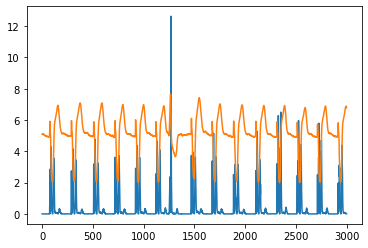

In [57]:
data = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/qtdbsel102.txt', sep='\t').reset_index()
data = np.array(data)

# データの分割
D = data[:6000,2]
Dtr = D[:3000]
T = len(D)

# 部分空間同定法：状態系列の推定
w = 5 # 窓幅
N = 1400 # 部分時系列の数

# 窓幅ずつデータを切り出す
x = np.array([Dtr[i:(i+w)] for i in range(len(Dtr)-w+1)]).T

# 行列XpとXfの作成
Xp = x[:,:N]
Xf = x[:,N:N*2]

# 分散行列・共分散行列の計算
Spf = Xp@Xf.T
Spp = Xp@Xp.T
Sff = Xf@Xf.T

# Wの作成
W = Spp**(-1/2)@Spf@Sff**(-1/2)
# Wの固有値分解
alpha = np.linalg.svd(W)[0]
beta = np.linalg.svd(W)[2].T
alpha = Spp**(-1/2)@alpha[:,0]
beta = Sff**(-1/2)@beta[:,0]

# 状態変数の系列の推定値
Zp = alpha.T@Xp
Zf = beta.T@Xf
z = np.concatenate([Zp,Zf])

# 部分空間同定法：未知パラメータ 𝐴,𝐶,𝑄,𝑅 の推定
# 観測行列と状態行列からなる行列
X = Dtr[:N*2-w]
Z = z[:N*2-w]

Z_p = z[1:N*2-w+1]
Z_m = z[:N*2-w]

# 𝐴,𝐶,𝑄,𝑅を計算する
A = (Z_p@Z_m.T)*(Z_m@Z_m.T)**(-1)
Q = 1/(len(Z)-1) * (Z_p - A*Z_m)@(Z_p - A*Z_m).T
C = (X@Z.T)*((Z@Z.T)**(-1))
R = 1/len(Z)*(X-C*Z)@(X-C*Z).T

# カルマンフィルタ
# 𝐴,𝐶,𝑄,𝑅(計算済み)以外のパラメータを与える
Q0 = 0.01
z0 = -1

# データの初期化
Kt = np.zeros(T) # カルマンゲイン
mut = np.zeros(T) # 平均
Vt = np.zeros(T) # 分散
Qt = np.zeros(T)
Qt[0] = Q0
mut[0] = z0/A

# カルマンフィルタの実行
# 各tのデータは保存しておく
for t in np.arange(1,T):
    Kt[t] = Qt[t-1]*C.T*(R+C*Qt[t-1]*C)**(-1)
    mut[t] = A*mut[t-1]+Kt[t]*(D[t]-C*A*mut[t-1])
    Vt[t] = (1-Kt[t]*C)*Qt[t-1]
    Qt[t] = Q + A*Vt[t]*A

# 分散行列の計算
Sig = R + C*Qt*C

# 異常度の計算
a = (D - C*A*mut)/Sig*(D - C*A*mut)

plt.plot(a[3000:])
plt.plot(D[3000:])

In [84]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                 6000
Model:             local linear trend   Log Likelihood                7813.483
Date:                Sun, 06 Mar 2022   AIC                         -15620.966
Time:                        15:05:18   BIC                         -15600.868
Sample:                             0   HQIC                        -15613.986
                               - 6000                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   2.52e-11   1.95e-05   1.29e-06      1.000   -3.82e-05    3.82e-05
sigma2.level         0.0009   7.39e-05     12.813      0.000       0.001       0.001
sigma2.trend         0.0026   4.82e-05     54.700      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                  20.02   Jarque-Bera (JB):            356064.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

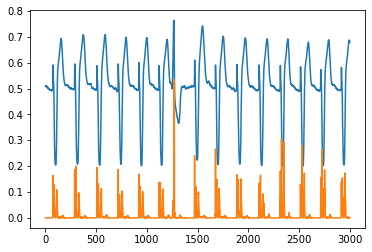

In [93]:
import statsmodels.api as sm

model = sm.tsa.UnobservedComponents(D, 'local linear trend')
result = model.fit()

plt.plot(D[3000:]*0.1)
plt.plot((D-result.predict(1,6000))[3000:]**2)

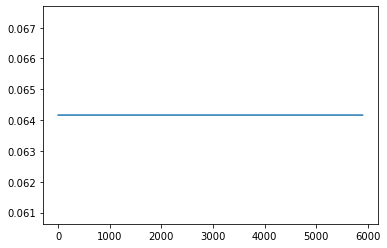

In [97]:
plt.plot(Sig[100:])